In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=1, float_l=1, aug_alpha=True),LossTracker(),SaveBest('weights/best_ie2a.h5'),EarlyStopping(10)])

1: Train=772.1491674804688 Valid=670.2036096191406
2: Train=493.8101806640625 Valid=500.8924639892578
3: Train=482.46254364013674 Valid=467.44879333496095
4: Train=410.2457341003418 Valid=465.81421813964846
5: Train=436.81043731689454 Valid=460.74176513671875
6: Train=470.17048797607424 Valid=434.5370764160156
7: Train=393.38306427001953 Valid=361.677763671875
8: Train=341.0078623962402 Valid=268.5640286254883
9: Train=236.591212310791 Valid=248.47625213623047
10: Train=189.39220779418946 Valid=281.68393768310546
11: Train=289.2692448425293 Valid=275.7465640258789
12: Train=292.7469883728027 Valid=346.2040625
13: Train=334.42333297729493 Valid=335.616513671875
14: Train=354.82347869873047 Valid=297.1086386108398
15: Train=272.5012260437012 Valid=301.61787780761716
16: Train=233.1660369873047 Valid=245.73700164794923
17: Train=247.50973770141601 Valid=265.16108795166014
18: Train=267.1653285217285 Valid=345.57060150146486
19: Train=394.3250088500977 Valid=337.97208801269534
20: Train=24

In [8]:
model.save('weights/Inferno_Test_exact_bm2a.h5')

In [9]:
model.load('weights/Inferno_Test_exact_bm2a.h5')

# Results

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,7,1.0
1,7,1.0
2,4,1.0
3,0,1.0
4,4,1.0


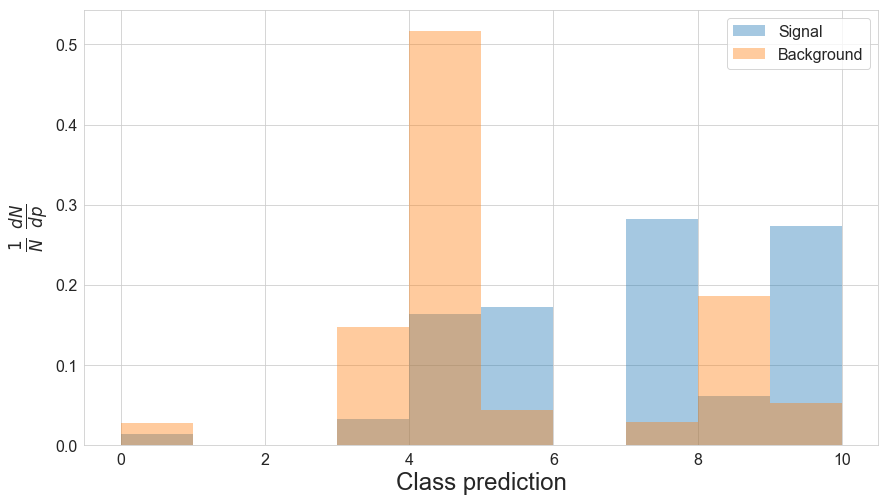

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [13]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,7,1.0,7
1,7,1.0,7
2,4,1.0,4
3,0,1.0,0
4,4,1.0,4


In [15]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [17]:
f_s, f_b

(tensor([1.3728e-02, 2.0000e-13, 2.0000e-13, 3.2540e-02, 1.6334e-01, 1.7253e-01,
         2.0000e-13, 2.8244e-01, 6.1526e-02, 2.7390e-01]),
 tensor([2.7624e-02, 2.0000e-13, 2.0000e-13, 1.4730e-01, 5.1733e-01, 4.2952e-02,
         2.0000e-13, 2.7968e-02, 1.8524e-01, 5.1596e-02]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([2.8310e+01, 2.1000e-10, 2.1000e-10, 1.4892e+02, 5.2549e+02, 5.1578e+01,
         2.1000e-10, 4.2090e+01, 1.8831e+02, 6.5291e+01]), tensor(1050.))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([24.16696167, 24.03722382, 23.91270447, 23.79304504, 23.67862701,
       23.56935883, 23.46463776, 23.36531067, 23.27055359, 23.1807251 ,
       23.09534454, 23.01467896, 22.93862152, 22.86702728, 22.80012512,
       22.7375412 , 22.67929077, 22.62512207, 22.57566833, 22.53040314,
       22.48921204, 22.45212555, 22.41915894, 22.39033508, 22.36543274,
       22.34459686, 22.32730865, 22.3139267 , 22.30458069, 22.29907227,
       22.2972641 , 22.29892731, 22.30432129, 22.31362915, 22.32640076,
       22.34264374, 22.36270905, 22.38559723, 22.41255951, 22.44267273,
       22.47631836, 22.51308441, 22.55338287, 22.59680176, 22.64350128,
       22.69348145, 22.746315  , 22.802742  , 22.86232758, 22.92472076,
       22.99023438, 23.05903625, 23.13059998, 23.2052536 , 23.28311157,
       23.36352539, 23.44715118, 23.53327179, 23.62251282, 23.7144928 ,
       23.80930328])

In [21]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [22]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

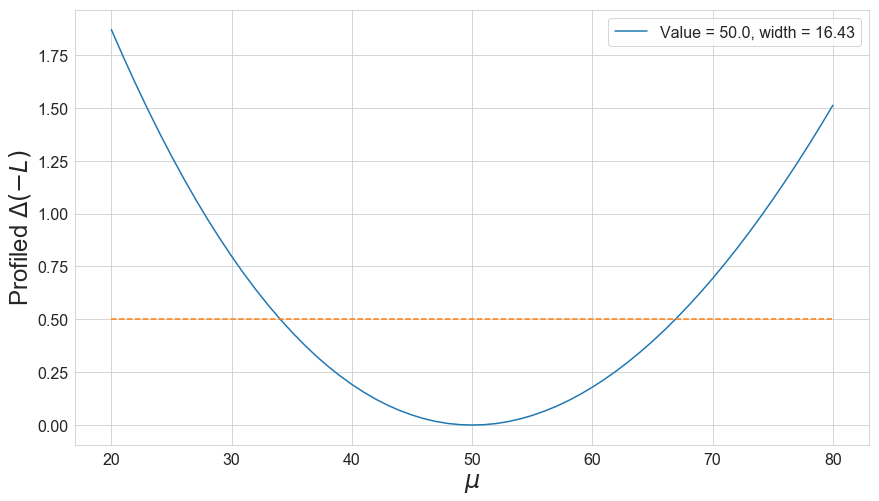

In [23]:
plot_likelihood(y-y.min())

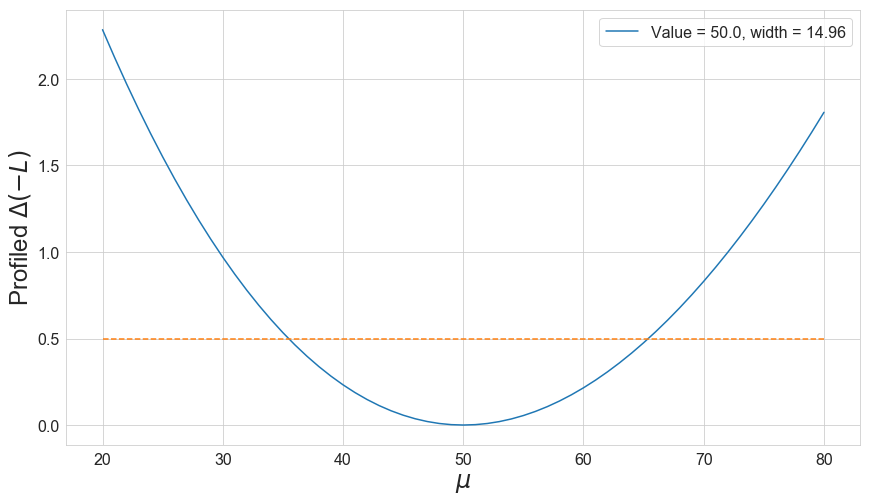

In [24]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [25]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [26]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [27]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,7,1.0,7,7,7,7,7,7,7,7,7,7,7
1,7,1.0,7,7,7,7,7,7,7,7,7,7,7
2,4,1.0,4,4,4,4,4,4,4,4,4,4,4
3,0,1.0,0,0,0,0,0,0,0,0,0,0,0
4,4,1.0,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,4,0.0,4,4,4,4,4,4,4,4,4,4,4
999996,8,0.0,8,8,8,8,8,9,9,8,8,8,8
999997,4,0.0,4,4,4,4,4,4,4,4,4,4,4
999998,3,0.0,3,3,3,3,3,3,3,3,3,3,3


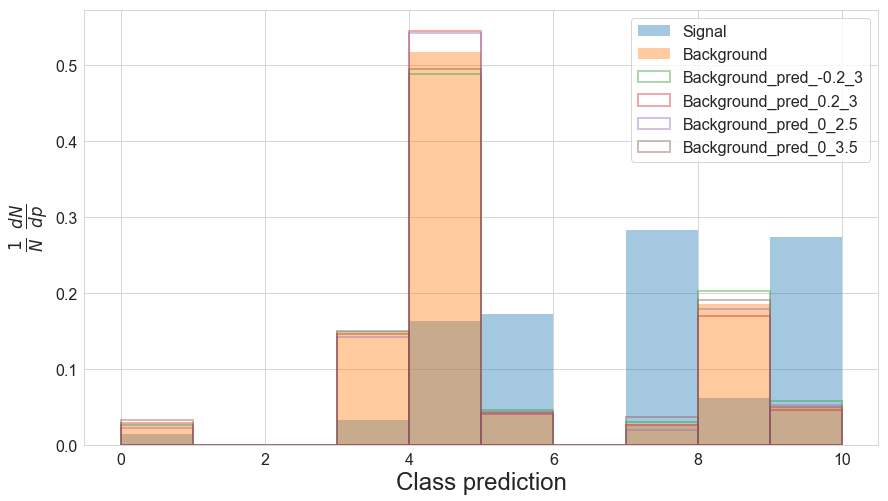

In [28]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([2.0942e-02, 2.0000e-13, 2.0000e-13, 1.4399e-01, 5.1325e-01, 4.4758e-02,
        2.0000e-13, 2.1588e-02, 1.9629e-01, 5.9184e-02])
tensor([2.6604e-02, 2.0000e-13, 2.0000e-13, 1.4873e-01, 4.8827e-01, 4.5694e-02,
        2.0000e-13, 2.9982e-02, 2.0267e-01, 5.8054e-02])
tensor([3.1848e-02, 2.0000e-13, 2.0000e-13, 1.5190e-01, 4.6527e-01, 4.6476e-02,
        2.0000e-13, 3.9186e-02, 2.0854e-01, 5.6790e-02])
tensor([2.1962e-02, 2.0000e-13, 2.0000e-13, 1.4256e-01, 5.4231e-01, 4.2016e-02,
        2.0000e-13, 1.9574e-02, 1.7885e-01, 5.2726e-02])
tensor([2.7624e-02, 2.0000e-13, 2.0000e-13, 1.4730e-01, 5.1733e-01, 4.2952e-02,
        2.0000e-13, 2.7968e-02, 1.8524e-01, 5.1596e-02])
tensor([3.2868e-02, 2.0000e-13, 2.0000e-13, 1.5047e-01, 4.9433e-01, 4.3734e-02,
        2.0000e-13, 3.7172e-02, 1.9110e-01, 5.0332e-02])
tensor([2.3176e-02, 2.0000e-13, 2.0000e-13, 1.4062e-01, 5.7035e-01, 3.9036e-02,
        2.0000e-13, 1.7576e-02, 1.6286e-01, 4.6388e-02])
tensor([2.8838e-02, 2.0000e-13, 2.0000e-1

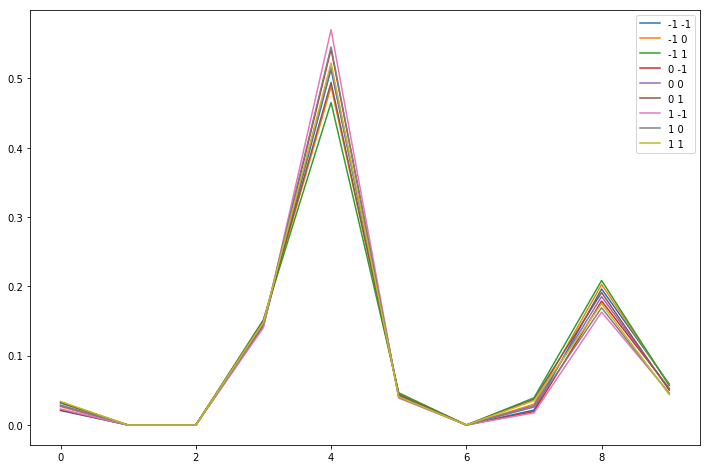

In [29]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [30]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [31]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [32]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [34]:
nll = to_np(nll)

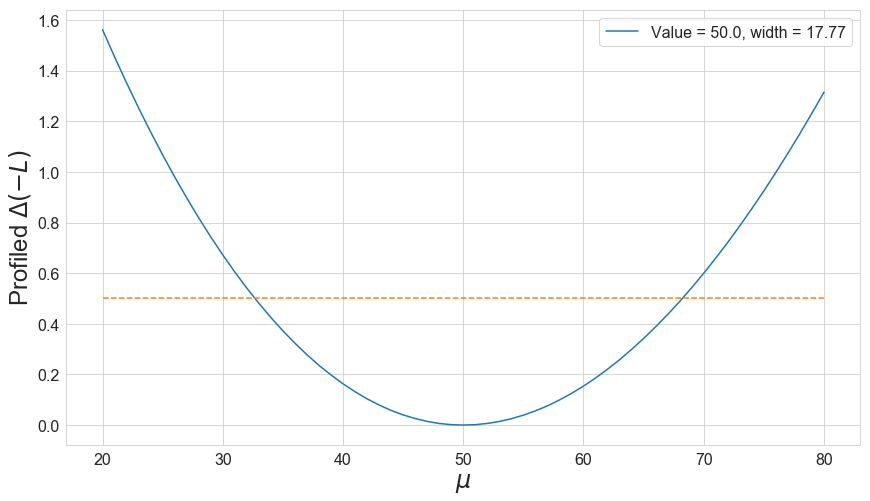

In [35]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [36]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [38]:
nll = to_np(nll)

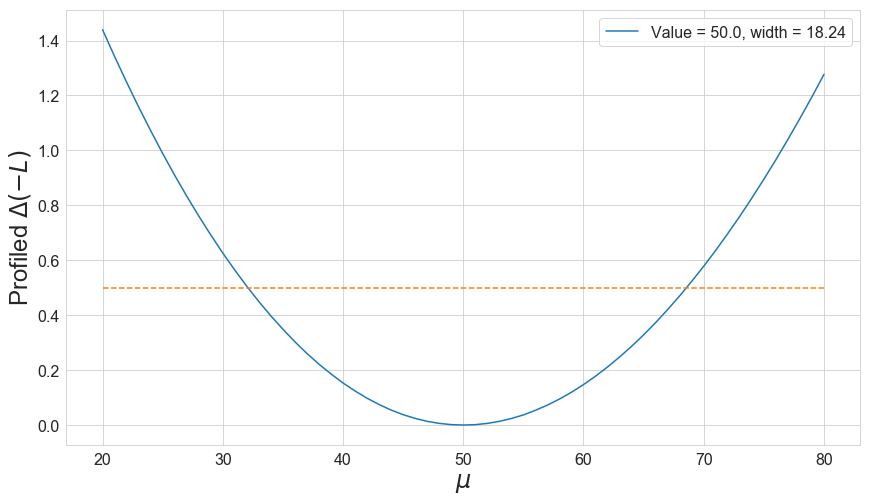

In [39]:
plot_likelihood(nll-nll.min())

## BM 2

In [40]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [41]:
nll = to_np(nll)

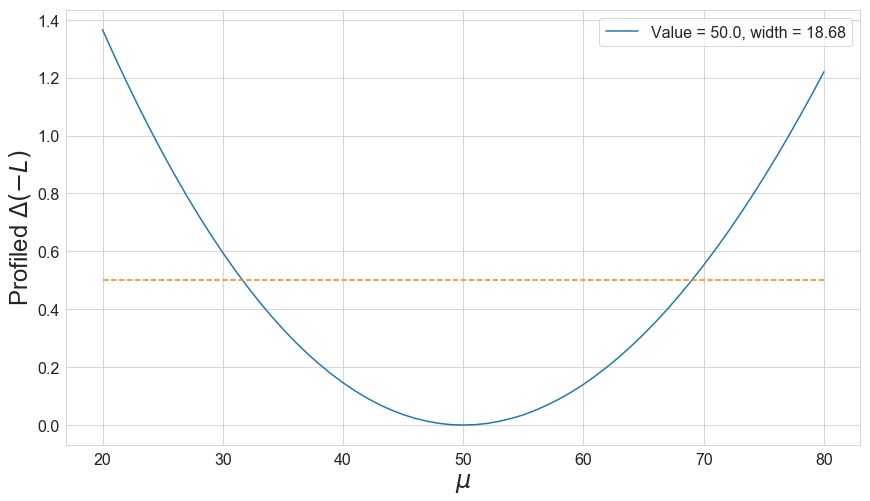

In [42]:
plot_likelihood(nll-nll.min())